# An Aspect Based Sentiment Analysis.

In my LDA topic model analysis of Tears of the Kingdom Reviews, I took a look at the different topics generated by running a topic model on negative, positive and mixed reviews. Those topics consisted of a selection of keywords which I then sumaries with blanket/umrella terms.  Here, I am going to be using an those very same keywords (as well as my own imagination and experience with the game) as aspects in "aspect based sentiment classifier" deep learning model. In this way I hope to obtain obtain a quantitative assessment of the sentiments toward each "aspects" of the game based on the reviews.

Let's a Go!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
sns.set_style('darkgrid')
from ast import literal_eval
from collections import Counter

# Importing the huggingface transformers model:
This model is found here: https://huggingface.co/yangheng/deberta-v3-base-absa-v1.1
It is an aspect based sentiment classifier. We can use this to classify the sentiments of aspects inside a piece of text. There is an example in the code below.


In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

model_name = "yangheng/deberta-v3-base-absa-v1.1"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)


In [2]:
for aspect in ['camera', 'phone']:
   print(aspect, classifier('The camera quality of this phone is amazing.',  text_pair=aspect))

camera [{'label': 'Positive', 'score': 0.9967294931411743}]
phone [{'label': 'Neutral', 'score': 0.947278618812561}]


<br>
As you can see the model classified the camera as having a positive sentiment and the phone with a neutral sentiment and from the sentence we can see this checks out. 

<br>
<br>

----





## Importing the Tears of the Kingdom User Reviews
We'll import the dataset containing the user reviews. This dataset is the one that has already been preprocessed in my notebook where I processed the All we need to do is to convert the review text into lower case. This is because we won't have to account for any case differences when matching aspects in the text.

In [48]:
totk_reviews = pd.read_csv('cleaned_totk_reviews.csv')


In [49]:
#Create a column containing the review text in lowercase.

totk_reviews['lowercase_reviews'] = totk_reviews.review_text.apply(lambda x: x.lower())

## Choosing Aspects
I'll use a mixture of my own knowledge to identify aspects as well as key words identified for the different topics in the LDA Topic Modelling analysis of these reviews done previously. Below is a selection of the topics fo each review category. 

Positive Review Topics

- graphic, bad, fps, performance, console, issue, problem, score, frame, little, fix, hardware, dlc, time, point.
- time, year, experience, absolutely, wait, finish, life, long, day, end , stop, spend, buy, gaming, worth
- world, story, mechanic, open, gameplay, beautiful, simply, explore, freedom, time, predecessor, previous, map, creativity, history
- gameplay, experience, world, adventure, character, challenge, series, design, narrative, truly, set, create, captivate, engage, moment
- weapon, fuse, time, hand ability, puzzle, item, combat, system, enemy, solve, build, allow, world, break
- map, story, sky, explore, dungeon boss, island, world, ability, depth, quest, underground, enemy, different, main

Negative Review Topics

- weapon, puzzle, item, build, shrine, break, time, dungeon, fight, enemy, mechanic, combat, fuse, building
- map, story, sky, repetitive, time, character, shrine, depth, interesting, main, island, quest, boss, place,
- bad, story, world, time, mechanic, graphic, previous, gameplay, experience, open, dlc, long, old, problem, system,
- map, fps, graphic, issue, price, low, critic, quality, hardware, score, developer, high, charge, face, poor

Negative/Mixed Review Topics

- sky, story, dungeon, map, island, shrine, time, big, boss, quest, depth, explore, interesting, main, ability
- gameplay, adventure, character, experience, completely, create, narrative, far, true, close, development expect, construction, addition, develop
- world, story, bad, mechanic, time, gameplay, open, previous, dlc, old, experience, build, problem, map, issue
- graphic, fps, console, performance, quality, price, hardware, low, poor, critic, level, choice, high, developer, score
- weapon, enemy, time, break, puzzle, item, shrine, combat, system, spend, fuse, grind, annoying, arrow, material


______

### Creating a set of aspects

We can use the absa model to quantitively evaluate the balance between positive and negative sentiments toward different aspects. For example 25% of sentiment toward the combat system could be negative, and 75% could be positive. 

First we will create a list of aspects from the topic key words and then afterward some will be sorted them under "umbrella aspects" and categories. The topic key words above are lemmatized so there are some words like "graphic" that in the documents wlll actually appear as "graphics".

Here is a list of aspects under umbrella terms:

Visual Presentation: "graphics", "visuals", "framerate", "fps", "frame rate". <br>

Combat : "combat", "weapons", "fuse", "weapons breaking", "weapon durability", "weapon breaking", "enemy", "enemy variety", "enemies", "boss", "bosses", "dungeon boss", "dungeon bosses", "mini-boss" "mini boss" "minibosses", "miniboss" "mini-bosses"
<br>

Story: "story", "plot", "narrative", "narratives", "character", "characters", "main quest", "main quests" <br>

Puzzles:  "puzzles", "puzzle", "shrines", "dungeons" <br>

Abilities: "abilities", "ability", "fuse", "ultrahand", "autobuild", "build", "building", "ascend", "recall", "mechanics" <br>
(Abilities are aggregated here but will be evaluated separately) <br>

Game World and Exploration: "world", "map", "maps", "exploration", "depths", "underground", "caves", "sky islands","sky island", "sky", "vehicles"<br>

Price: "price", "cost" <br>

User Interface : "menu", "interface", "user interface", "UI"

Side Quests:  "sidequest", "side quest", "side adventures", "side adventure"

Soundtrack:  "music", "soundtrack", "score"

Miscellaneous: "Quests", "quests", "gameplay", "mechanics"

Caves: "caves" and "cave"

Depths: "depths" and "underground" and "under ground"




- Below we can create a list of aspects
- To speed things up later, lets identify reviews that have at least on aspect within them and then filter for those in our analysis.

In [5]:

aspects = [
    "weapons breaking", "weapon durability", "weapon breaking", "weapons break", "weapon breaks",
    "weapons system", "weapon system",
    "side quests", "side adventures", "sidequests",
    "user interface", "ultra hand", "auto build",
    "final boss", "mini-boss", "mini boss", "mini-bosses", "minibosses", "dungeon bosses", "boss fight",
    "monster variety", "enemy variety", "sky islands", "zonai devices",
    "soundtrack", "visuals", "framerate", "frame rate", "armours",
    "graphics", "combat", "weapons", "health", "narratives", "characters", "abilities", "shrines", "temples",
    "depths", "dungeons", "ultrahand", "autobuild", "building", "clothing", "fusing", "exploration",
    "interface", "monsters", "vehicles", "recall", "ascend", "armour", "ability", "monster", "enemies",
    "dungeon boss", "bossfight", "bossfights", "bosses", "enemy", "gloom", "music", "score", "plot", "story",
    "narrative", "storyline", "puzzles", "puzzle", "price", "cost", "quests", "quest", "menu", "menus",
    "crafting", "cooking", "hyrule", "items", "map", "maps", "world", "sky island", "sky", "caves", "cave",
    "depths", "fps", "ui", "build", "fuse", "zonai device", "hit points", "hp", "clothes", "main quests",
    "main quest", "mechanics", "gameplay"
]

#list of tuples containing  (aggregate term, list of terms to aggregate)
agg_terms = [('SideQuests',['side quests','sidequests']), 
              ("User Interface",["ui","interface","user interface","menu", "menus"]),
              ("Price",["price","cost"]), 
              ("Sky",["sky islands","sky", "sky island"]),
              ("Dungeons",["dungeons", "temples",]),
              ("Armour",["armour", "armours", "clothing", "clothes"]),
              ("Health",["hp","health","hit points"]),
              ("Ability",["abilities","ability"]),
              ("Zonai Devices",["zonai devices", "zonai device"]),
              ("Plot/Story",["plot","story","narrative","narratives","storyline"]), 
              ("Puzzles",["puzzles","puzzle"]),
              ("AutoBuild",["autobuild","auto build", "auto build"]), 
              ("World",["map","maps","world"]),
              ('Framerate', ['fps','frame rate','framerate']), 
              ("Main Quests",["main quests", "main quest"]),
              ("Build", ["build", "building"] ), 
              ("Quests", ["quests", "quest"]),
              ("Weapon Durability", ["weapon breaking", "weapons breaking", "weapon durability", "weapon system", "weapons system",
                                     "weapons break", "weapon breaks"]),
              ("Ultrahand", ["ultra hand", "ultrahand"]),
              ("Enemies",['enemy', 'enemy variety', 'enemies', "monster", "monsters","monster variety"]),
              ("Bosses",['boss', 'bosses', 'dungeon boss', 'dungeon bosses', 'mini-boss', 'mini boss', 
                         'minibosses', 'miniboss', 'mini-bosses', 'bossfight','bossfights', 'boss fight']), 
              ("Soundtrack", ["music", "soundtrack", "score"]),
              ("Depths", ["depths", "underground", "under ground"]),
              ("Caves",["cave", "caves"])]

agg_terms_dict = dict(agg_terms)

synonym_set = set([synonym for _, synonyms in agg_terms for synonym in synonyms])

# Collect agg terms and aspects not in synonym_set
refined_aspects = [agg[0] for agg in agg_terms] + [aspect for aspect in aspects if aspect not in synonym_set]


## Identifying and Classifying Aspects

#### Filtering out irrelevant reviews
We'll add a column of boolean values to the dataframe called "has_aspect" so we can filter out reviews that have no aspects from the list mentioned in their text.

In [6]:
#Creates the column by checking for words in the aspect list using regex and str.contains method from pandas.
totk_reviews['has_aspect'] = totk_reviews.lowercase_reviews.str.contains(r'\b('+r'|'.join(word for word in aspects)+r')\b',regex=True)

C:\Users\User\AppData\Local\Temp\ipykernel_1440\1501789826.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  totk_reviews['has_aspect'] = totk_reviews.lowercase_reviews.str.contains(r'\b('+r'|'.join(word for word in aspects)+r')\b',regex=True)


In [7]:
#Create a new dataframe only containing reviews with identifiable aspects within their text
totk_reviews_wa = totk_reviews[totk_reviews['has_aspect']==True]

the "wa" is not a reference to "waluigi". 

It represents something deeper.

"with aspects"

In [57]:
del totk_reviews #We no longer need the original dataframe

#### Defining some useful functions:
We need 3 simple functions:
- One will take a list of aspects and create a dictionary with each aspect being a key and their values being a nested dictionary with key-value pairs of both sentiment and sentiment count
- We need a function that takes a list of aspects found within a review and then runs the classifier on the text for each aspect and then adding to the sentiment count in the dictionary we have created.
- We need a function that we can use to add a column to the dataframe that contains a list of aspects found within each review.
- To make things easier later let's create a function that aggregates synonyms here and now. 

The aggregation function will do the following:
- check if the aspect is in fact "synonymous" with one of the umbrella/summary terms.
- create a sentiment_value variable
- classify each aspect but adding a numerical value of 0,1,-1 depending on neutral, positive or negative classification to "sentiment_value"
- The sign in front the sentiment_value will determine if it will be classified in the aspect_dictionary as pos, neg or neu
- If the aspect is not  synonym then it will be classified as normal.

In [9]:
def counter_dictionary(keylist):
    #Give this function a list of keys and it will return a dictionary with a subdict containing a sentiment and value count
    
    output_dictionary = {}
    for k in keylist:
        output_dictionary.update({k:{'Positive':0,'Negative':0, 'Neutral':0}})
    return output_dictionary




def sentiment_classification_count(sentence, aspect_list,aspect_dict):

    #create a list of  known aspects found within the review text.
    sentence_aspects = list(set(re.findall(r'\b('+r'|'.join(word for word in aspect_list)+r')\b', sentence)))

    #for each aspect run the sentiment classifier adding a point to the respective aspect and sentiment to the aspect dictionary
    for aspect in sentence_aspects:
       classifier_output = classifier(sentence,  text_pair=aspect)
       if classifier_output[0]['label'] == 'Negative':
           aspect_dict[aspect]['Negative'] +=1
       elif classifier_output[0]['label'] == 'Positive':
           aspect_dict[aspect]['Positive'] +=1
       elif classifier_output[0]['label'] == 'Neutral':
           aspect_dict[aspect]['Neutral'] +=1
       else:
           pass
    return sentence_aspects #return the list of aspects at the end 

------

In [56]:
s_r = 'the weapons I like i master sword annoying it breaks bad weapons system i dont like weapons breaking'
list((re.findall(pattern, s_r)))

['weapons', 'weapons', 'weapons']

In [10]:
pattern = r'\b('+r'|'.join(word for word in aspects)+r')\b'

In [11]:
agg_terms_keys = list(agg_terms_dict.keys())

In [12]:
aspect_dict = counter_dictionary(refined_aspects)

In [13]:
point_mapper = {'Negative': -1, 'Positive': 1, 'Neutral': 0}

In [14]:
def sentiment_classification_count(sentence, aspect_dict):

    #create a list of  known aspects found within the review text.
    sentence_aspects = list(set(re.findall(pattern, sentence)))

    
    index_list = [i for i, values in enumerate(agg_terms_dict.values()) for a in sentence_aspects if a in values]
    unique_asps = [a for a in sentence_aspects if all(a not in values for values in agg_terms_dict.values())]
    for a in unique_asps:
        classifier_output = classifier(sentence, text_pair=a)
        if classifier_output[0]['label'] == 'Negative':
           aspect_dict[a]['Negative'] +=1
        elif classifier_output[0]['label'] == 'Positive':
           aspect_dict[a]['Positive'] +=1
        elif classifier_output[0]['label'] == 'Neutral':
           aspect_dict[a]['Neutral'] +=1
        else:
           pass
    
    for i in list(set(index_list)):
        count = 0
        aggregated_aspects = list(agg_terms_dict.values())[i]
        for asp in aggregated_aspects:
            if asp in sentence_aspects:
                classifier_output = classifier(sentence,  text_pair=asp)
                count += point_mapper[classifier_output[0]['label']]
        
        if count > 0:
            aspect_dict[agg_terms_keys[i]]['Positive'] +=1
        elif count == 0:
            aspect_dict[agg_terms_keys[i]]['Neutral'] +=1
        elif count <0 :
            aspect_dict[agg_terms_keys[i]]['Negative'] +=1
    
    
    return sentence_aspects #return the list of aspects at the end 

In [15]:
totk_reviews_wa['aspects_within'] = totk_reviews_wa.lowercase_reviews.apply(lambda x :sentiment_classification_count(x, aspect_dict))

#### Inspecting our dictionary:

In [16]:
aspect_dict

{'SideQuests': {'Positive': 94, 'Negative': 39, 'Neutral': 11},
 'User Interface': {'Positive': 20, 'Negative': 52, 'Neutral': 1},
 'Price': {'Positive': 38, 'Negative': 73, 'Neutral': 6},
 'Sky': {'Positive': 282, 'Negative': 113, 'Neutral': 113},
 'Dungeons': {'Positive': 228, 'Negative': 171, 'Neutral': 77},
 'Armour': {'Positive': 8, 'Negative': 15, 'Neutral': 2},
 'Health': {'Positive': 8, 'Negative': 9, 'Neutral': 2},
 'Ability': {'Positive': 329, 'Negative': 82, 'Neutral': 27},
 'Zonai Devices': {'Positive': 14, 'Negative': 10, 'Neutral': 4},
 'Plot/Story': {'Positive': 1003, 'Negative': 327, 'Neutral': 91},
 'Puzzles': {'Positive': 245, 'Negative': 110, 'Neutral': 43},
 'AutoBuild': {'Positive': 4, 'Negative': 6, 'Neutral': 1},
 'World': {'Positive': 1205, 'Negative': 325, 'Neutral': 180},
 'Framerate': {'Positive': 90, 'Negative': 161, 'Neutral': 3},
 'Main Quests': {'Positive': 22, 'Negative': 14, 'Neutral': 7},
 'Build': {'Positive': 216, 'Negative': 119, 'Neutral': 25},
 'Q

In [23]:
#creating a copy of the dictionary thatwe can edit and create a dataframe out of
aspect_sentiment_counts = aspect_dict.copy()

After running the function let's re-inspect our dictionary. Then we can create a dataframe based on this which we will use to visualise the data for easy comparisons.

In [24]:
aspect_sentiment_counts

{'SideQuests': {'Positive': 94, 'Negative': 39, 'Neutral': 11},
 'User Interface': {'Positive': 20, 'Negative': 52, 'Neutral': 1},
 'Price': {'Positive': 38, 'Negative': 73, 'Neutral': 6},
 'Sky': {'Positive': 282, 'Negative': 113, 'Neutral': 113},
 'Dungeons': {'Positive': 228, 'Negative': 171, 'Neutral': 77},
 'Armour': {'Positive': 8, 'Negative': 15, 'Neutral': 2},
 'Health': {'Positive': 8, 'Negative': 9, 'Neutral': 2},
 'Ability': {'Positive': 329, 'Negative': 82, 'Neutral': 27},
 'Zonai Devices': {'Positive': 14, 'Negative': 10, 'Neutral': 4},
 'Plot/Story': {'Positive': 1003, 'Negative': 327, 'Neutral': 91},
 'Puzzles': {'Positive': 245, 'Negative': 110, 'Neutral': 43},
 'AutoBuild': {'Positive': 4, 'Negative': 6, 'Neutral': 1},
 'World': {'Positive': 1205, 'Negative': 325, 'Neutral': 180},
 'Framerate': {'Positive': 90, 'Negative': 161, 'Neutral': 3},
 'Main Quests': {'Positive': 22, 'Negative': 14, 'Neutral': 7},
 'Build': {'Positive': 216, 'Negative': 119, 'Neutral': 25},
 'Q

In [25]:
#Create a new dataframe
aspect_sentiment_df = pd.DataFrame.from_dict(aspect_sentiment_counts, orient='index').reset_index().rename({'index':'Aspect'},axis='columns')


Below we'll make a function that replaces the names of the aspects within the original dataframe. 

In [26]:
def aspect_name_replacement(aspect_list):
        
        aspects_within = [char for char in aspect_list]
        
        series = pd.Series(aspects_within)
        
        series.replace({
                        "side quests": "SideQuests", "sidequests": "SideQuests",
                        "ui": "User Interface", "interface": "User Interface", "user interface": "User Interface", "menu": "User Interface", "menus": "User Interface",
                        "price": "Price", "cost": "Price",
                        "sky islands": "Sky", "sky": "Sky", "sky island": "Sky",
                        "dungeons": "Dungeons", "temples": "Dungeons",
                        "armour": "Armour", "armours": "Armour", "clothing": "Armour", "clothes": "Armour",
                        "hp": "Health", "health": "Health", "hit points": "Health",
                        "abilities": "Ability", "ability": "Ability",
                        "zonai devices": "Zonai Devices", "zonai device": "Zonai Devices",
                        "plot": "Plot/Story", "story": "Plot/Story", "narrative": "Plot/Story", "narratives": "Plot/Story", "storyline": "Plot/Story",
                        "puzzles": "Puzzles", "puzzle": "Puzzles",
                        "autobuild": "AutoBuild", "auto build": "AutoBuild",
                        "map": "World", "maps": "World", "world": "World",
                        "fps": "Framerate", "frame rate": "Framerate", "framerate": "Framerate",
                        "main quests": "Main Quests", "main quest": "Main Quests",
                        "build": "Build", "building": "Build",
                        "quests": "Quests", "quest": "Quests",
                        "weapon breaking": "Weapon Durability", "weapons breaking": "Weapon Durability", "weapon durability": "Weapon Durability",
                        "weapon system": "Weapon Durability", "weapons system": "Weapon Durability",
                        "weapons break": "Weapon Durability", "weapon breaks": "Weapon Durability",
                        "ultra hand": "Ultrahand", "ultrahand": "Ultrahand",
                        "enemy": "Enemies", "enemy variety": "Enemies", "enemies": "Enemies", 
                        "monster": "Enemies", "monsters": "Enemies", "monster variety": "Enemies",
                        "boss": "Bosses", "bosses": "Bosses", "dungeon boss": "Bosses", "dungeon bosses": "Bosses",
                        "mini-boss": "Bosses", "mini boss": "Bosses", "minibosses": "Bosses",
                        "miniboss": "Bosses", "mini-bosses": "Bosses", "bossfight": "Bosses", 
                        "bossfights": "Bosses", "boss fight": "Bosses",
                        "soundtrack": "Soundtrack", "music": "Soundtrack", "score": "Soundtrack",
                        "depths": "Depths", "underground": "Depths", "under ground": "Depths",
                        "cave": "Caves", "caves": "Caves",
                        'graphics': 'Graphics', 'visuals': 'Visuals','combat': 'Combat','weapons': 'Weapons',
                        'fuse': 'Fuse','fusing': 'Fusing','fusion': 'Fusion','gloom': 'Gloom','characters': 'Characters',
                        'final boss': 'Final Boss','exploration': 'Exploration','shrines': 'Shrines','ascend': 'Ascend',
                        'recall': 'Recall','vehicles': 'Vehicles','gameplay': 'Gameplay','mechanics': 'Mechanics',
                        'side adventures': 'Side Adventures','hyrule': 'Hyrule','items': 'Items','crafting': 'Crafting','cooking': 'Cooking'
                        
                    }, inplace=True)
        #returns the series as a list
        return series.tolist()
        

In [27]:
totk_reviews_wa['updated_aspects_within'] = totk_reviews_wa.aspects_within.apply(lambda x: aspect_name_replacement(x))

-----

## Visualising data:
First, we'll create a new a column to our dataframe with our aspects and their sentiment value counts. This column will tell us how many times the aspect was mentioned at least once across all reviews.

In [28]:
aspect_sentiment_df = (
    aspect_sentiment_df.assign(Total_Count = lambda x: x.Positive + x.Negative + x.Neutral))


In [29]:


aspect_sentiment_df['Aspect'].replace({
                            "side quests": "SideQuests", "sidequests": "SideQuests",
                            "ui": "User Interface", "interface": "User Interface", "user interface": "User Interface", "menu": "User Interface",
                            "price": "Price", "cost": "Price",
                            "sky islands": "Sky", "sky": "Sky", "sky island": "Sky",
                            "depths": "Depths", "underground": "Depths", "under ground": "Depths",
                            "cave": "Caves", "caves": "Caves", 
                            "abilities": "Ability", "ability": "Ability",
                            "plot": "Plot", "story": "Plot", "narrative": "Plot", "narratives": "Plot", 
                            "puzzles": "Puzzles", "puzzle": "Puzzles",
                            "autobuild": "AutoBuild", "auto build": "AutoBuild",
                            "map": "World", "maps": "World", "world": "World",
                            "fps": "Framerate", "frame rate": "Framerate", "framerate": "Framerate",
                            "main quests": "Main Quests", "main quest": "Main Quests",
                            "build": "Build", "building": "Build",
                            "quests": "Quests", "quest": "Quests",
                            "weapon breaking": "Weapon Durability", "weapons breaking": "Weapon Durability", 
                            "weapon durability": "Weapon Durability", "weapon system": "Weapon Durability",
                            "ultra hand": "Ultrahand", "ultrahand": "Ultrahand",
                            "enemy":"Enemies", "enemies":"Enemies", "enemy variety":"Enemies", "monster":"Enemies", "monsters":"Enemies", "monster variety":"Enemies",
                            "boss":"Bosses", "bosses":"Bosses", "dungeon boss":"Bosses", "dungeon bosses":"Bosses", "mini-boss":"Bosses", "mini boss":"Bosses", "minibosses":"Bosses", 
                            "miniboss":"Bosses", "mini-bosses":"Bosses", "bossfight":"Bosses","bossfights":"Bosses", "boss fight":"Bosses",
                            "soundtrack" : "Soundtrack", "music" : "Soundtrack", "score": "Soundtrack",
                            "graphics": "Graphics", "visuals":"Visuals", "ui":"UI","final boss": "Final Boss", 
                            "fuse":"Fuse", "weapons":"Weapons","combat":"Combat", "dungeons":"Dungeons", "shrines":"Shrines",
                            "mechanics":"Mechanics", "gameplay":"Gameplay", "ascend":"Ascend","recall":"Recall", 
                            "side adventures":"Side Adventures", "characters":"Characters", "exploration":"Exploration", "vehicles":"Vehicles",
                            'graphics': 'Graphics', 'visuals': 'Visuals','combat': 'Combat','weapons': 'Weapons',
                            'fuse': 'Fuse','fusing': 'Fusing','fusion': 'Fusion','gloom': 'Gloom','characters': 'Characters',
                        'final boss': 'Final Boss','exploration': 'Exploration','shrines': 'Shrines','ascend': 'Ascend',
                        'recall': 'Recall','vehicles': 'Vehicles','gameplay': 'Gameplay','mechanics': 'Mechanics',
                        'side adventures': 'Side Adventures','hyrule': 'Hyrule','items': 'Items','crafting': 'Crafting','cooking': 'Cooking'
                            
                       },inplace = True)

In [30]:
aspect_sentiment_df

,Aspect,Positive,Negative,Neutral,Total_Count
0,SideQuests,94,39,11,144
1,User Interface,20,52,1,73
2,Price,38,73,6,117
3,Sky,282,113,113,508
4,Dungeons,228,171,77,476
5,Armour,8,15,2,25
6,Health,8,9,2,19
7,Ability,329,82,27,438
8,Zonai Devices,14,10,4,28
9,Plot/Story,1003,327,91,1421


## For future use I will save the two dataframes to csv
(If I want to revisit so I don't have to run the model again)

In [60]:
aspect_sentiment_df.to_csv('TOTK_aspect_sentiment_counts.csv')

In [59]:
totk_reviews_wa.to_csv('totk_reviews_with_aspects.csv')

In [2]:
totk_reviews_wa = pd.read_csv('totk_reviews_with_aspects.csv',index_col=0)


When we import this cv the list of aspects in the "updated_aspects_within" will actually be a pandas object type. By using literal_eval we can convert 
it to a list.

I am aware that the name of the column is wordy, it's just for me. If you want to use this as a template I suggest coming up with a better one!

In [3]:

totk_reviews_wa['updated_aspects_within'] = totk_reviews_wa.updated_aspects_within.apply(lambda x: literal_eval(x))


## Visualising The Data

In the beginning I decided to group certain aspects under certain umbrella categories.

Below is a list of tuples with three values:
1. A list of aspects
2. An integer
3. String

These will be called as the parameters of a function used to plot 2 graphs for each "Aspect Category".

In [46]:
aggregated_aspects = [(["Framerate","Graphics","Visuals", "Soundtrack"],0, "Presentation"),
                      (["Combat","Weapons","Fuse","Fusing","Weapon Durability", "Armour","Gloom", "Health"],1, "Combat"),
                      (["Bosses","Enemies","Final Boss"],2,"Bosses & Enemies"),
                      (["Puzzles","Shrines","Dungeons"],3, "Puzzles and Dungeons"),
                      (["Plot/Story","Characters","Main Quests"],4, "Main Story and Quests"), 
                      (["Ability","Ultrahand","Recall","Ascend","AutoBuild", "Build","Vehicles","Crafting","Cooking", "Zonai Devices"],5, "Abilities"),
                      (["Quests","SideQuests", "Side Adventures"],6, "SideQuests and Side Adventures"),
                      (["World","Sky", "Depths", "Exploration", "Caves","Hyrule"],7, "World and Exploration"),
                      (["Mechanics", "Gameplay","User Interface","Price","Items"],8, "Miscellaneous"),
                      ]

In [85]:


def sentiment_proportions(df_,df2_,elem, num, title):


    #Plots the count of apsect mentions in each review category
    (df2_.explode('updated_aspects_within')
    .query('updated_aspects_within.isin(@elem)')
    .groupby(['updated_aspects_within','review_sentiment'])['review_sentiment']
    .count()
    .unstack()
    .plot.bar(ax = ax[0], title='Frequency of Mentions in Review Categories', rot = 65)
    )
    ax[0].set_xlabel('', rotation=0)
    #retrieves the y tick values for the plot
    yticks_mentions = ax[0].get_yticks()
    
    ax[0].set_yticks(yticks_mentions)

    
    #Plots bar chart of the aspects showing the proportions of negative positive and neutral repsonses.

    data_neg = (
    aspect_sentiment_df.set_index('Aspect')
    .query('Aspect.isin(@elem)')['Negative']
    .plot.bar(ax=ax[1],color='firebrick',label='Negative Sentiments',title=title, rot=65)
    )
    data_pos = (
        aspect_sentiment_df.set_index('Aspect')
        .query('Aspect.isin(@elem)')['Positive']
        .plot.bar(ax=ax[1],color='lightblue',position=-0.15,label='Positive Sentiments', rot=65)
    )
    data_neu = (
        aspect_sentiment_df.set_index('Aspect')
        .query('Aspect.isin(@elem)')['Neutral']
        .plot.bar(ax=ax[1],color='orange',position=0.15,label='Neutral Sentiments', rot = 65, title = 'Frequency of Sentiment Classifications')
    )
    ax[1].legend(loc='best')
    ax[1].set_yticks(yticks_mentions)
    ax[0].set_ylabel('', rotation=0)
    
    
    
    

# Identifying Aspects That Could Improve.

We'll create two plots per Category. One showing the number of negative, neutral or positive sentiments an aspect recieves and the other displaying the number of times it's _mentioned_ in a review of a certain sentiment category (positive, negative or mixed reviews).

------


## Presentation

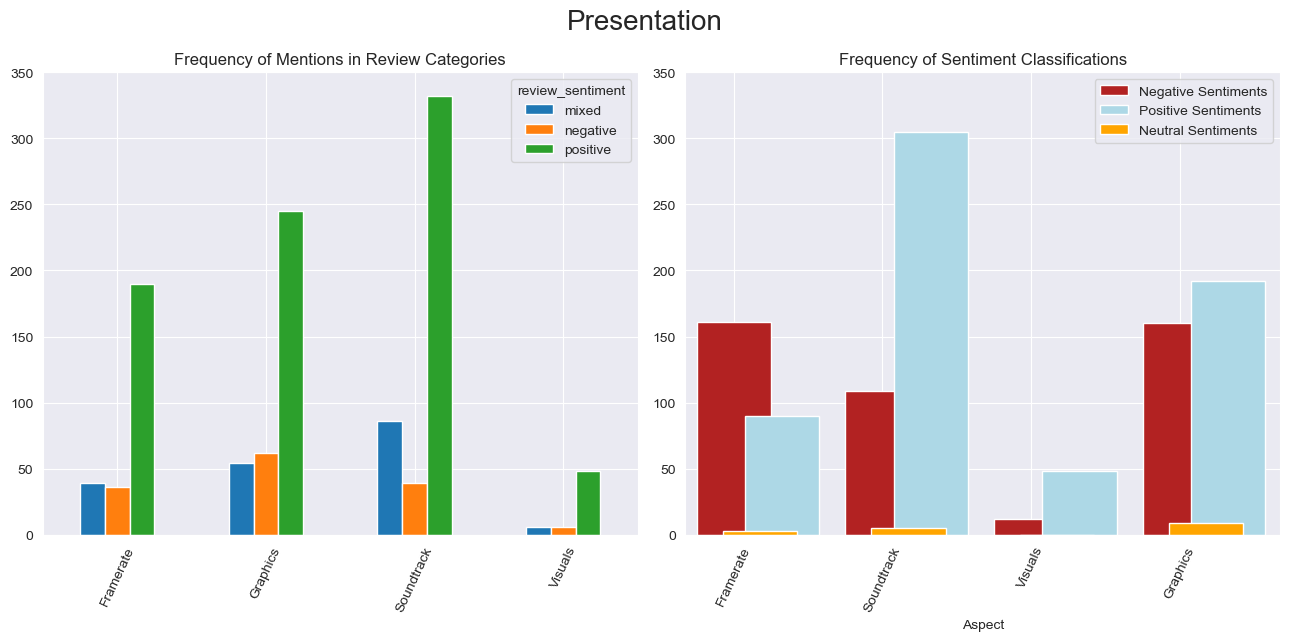

In [93]:
fig, ax = plt.subplots(1,2,figsize=(13,6.5))
fig.suptitle('Presentation', fontsize = 20)
elem, i, title = aggregated_aspects[0]
sentiment_proportions(aspect_sentiment_df,totk_reviews_wa,elem, i, title)
plt.tight_layout();

#### Key Observations:

- Framerate: The obvious pain-point and the chief complaint identified inside user reviews with it recieveing almost double the amount of negative responses than positive ones. 
- Graphics: Graphics can itself encompass many aspects, ultimately it can only be interpreted vaguely. With a near 50/50 ratio of positive:negative/neutral responses. Issues are likely overlapping with framerate.
- Visuals:  A vague aspect that that could be less related to technical performance as it is visual _direction_ which seems to be positively recieved albeit mentioned infrequently. (At this time I recognise the "artstyle" is an aspect worth exploring).

Both aspects 'graphics' and 'framerate' have a greater sum of negative sentiments that mentions in negative or mixed reviews. Meaning that even reviewers who gave an overall positive review felt need to criticise this aspect.

-------

## Combat


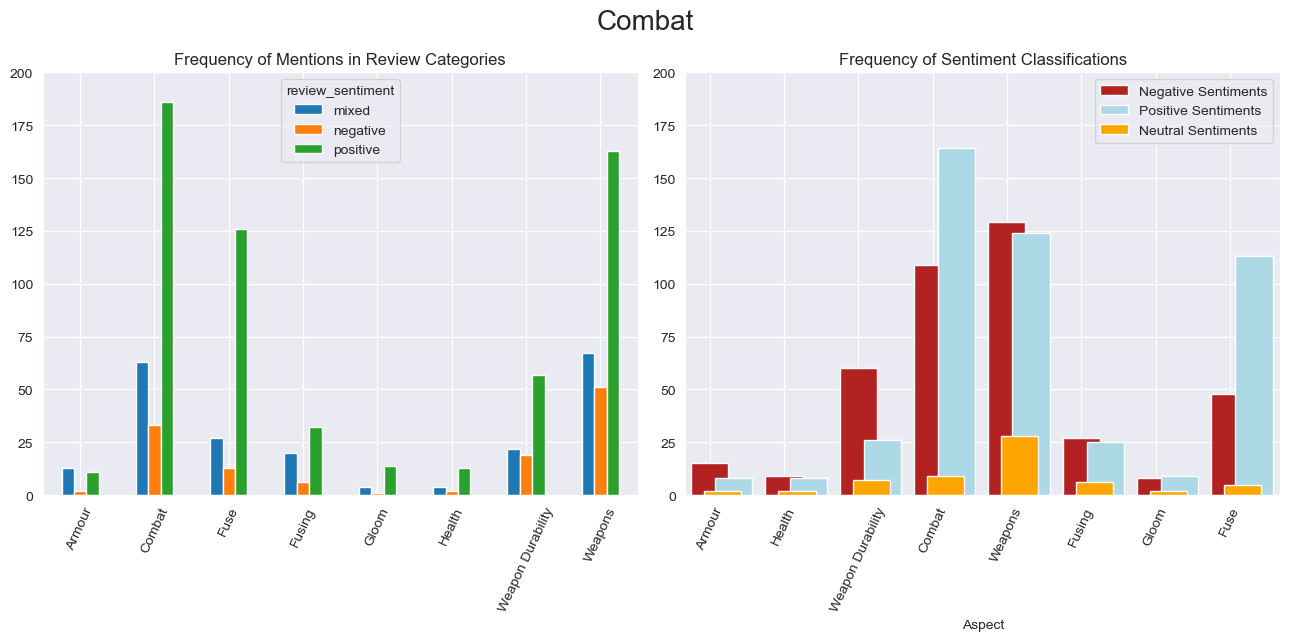

In [94]:
fig, ax = plt.subplots(1,2,figsize=(13,6.5))
fig.suptitle('Combat', fontsize = 20)
elem, i, title = aggregated_aspects[1]
sentiment_proportions(aspect_sentiment_df,totk_reviews_wa,elem, i, title)

plt.tight_layout();

### Key Observations:
- Weapons: With a near 50/50 split between positive and negative sentiments, reviewers found some issue with "weapons" that needs to be addressed. However it is a vague category, and could concern: weapon durability , weapon variety, crafting, weapon fusing etc
- Weapon Durability: Self-explanatory. This is something people hate. It has more negative sentiments that mentions in a positive review.
- Combat: Vague once more but with a mixed/positive opinion. Once again this will have crossover with weapon durability, enemy variety, controls etc. But overall there is a strong indication that players enjoyed the combat system overall.
- Fusing and Fuse: Fuse as an ability is very well recieved, however 'fusing' - the process of _using_ the ability has a mixed response with a ~ 50/50 split between positive and negative reviews.

#### Niche 
- Armour: Draws more criticism than praise.
- Health: Mixed response among players
- Gloom: Mixed response from players.
---------


## Bosses And Enemies

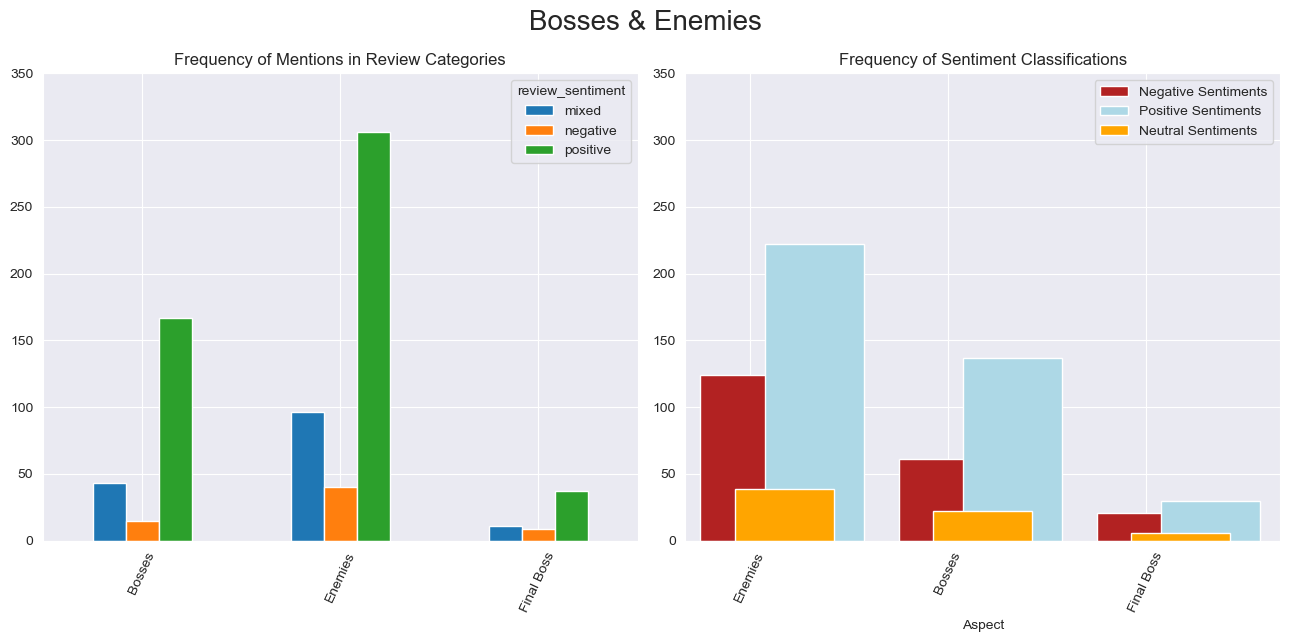

In [95]:
fig, ax = plt.subplots(1,2,figsize=(13,6.5))
fig.suptitle('Bosses & Enemies', fontsize = 20)
elem, i, title = aggregated_aspects[2]
sentiment_proportions(aspect_sentiment_df,totk_reviews_wa,elem, i, title)

plt.tight_layout();

### Key Observations:
Across the board the response toward the enemies is largely positive.

- Enemies: More negative sentiments than mentions in negative reviews. Fewer positive responses than positive reviews. An aspect reviewers who overall enjoyed the game took issue with.
- Final Boss: Some mixed response toward the final boss.
- Bosses: Significant praise.

"Bosses" is an encompassing term that references every boss fight in the game and so playrs may be refering to the final boss when brining up the topic of "bosses", "bossfights" etc. 

-------
## Puzzles and Dungeons

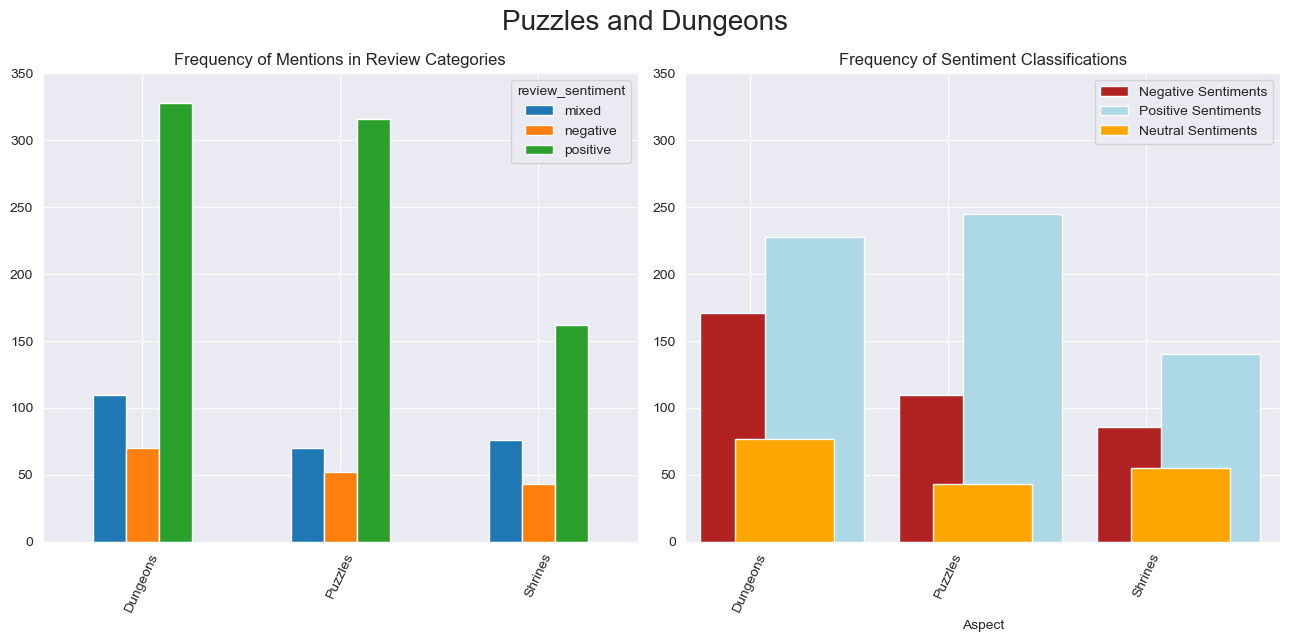

In [96]:
fig, ax = plt.subplots(1,2,figsize=(13,6.5))
fig.suptitle('Puzzles and Dungeons', fontsize = 20)
elem, i, title = aggregated_aspects[3]
sentiment_proportions(aspect_sentiment_df,totk_reviews_wa,elem, i, title)

plt.tight_layout();

### Key Observations:
- Dungeons: Mainly positive responses but still there are ~ 70% the number of posiive reviews as negative reviews.
- Puzzles: Primarily positive response.
- Shrines: Primarily positive response to shrines.
--------

## Main Story and Quests

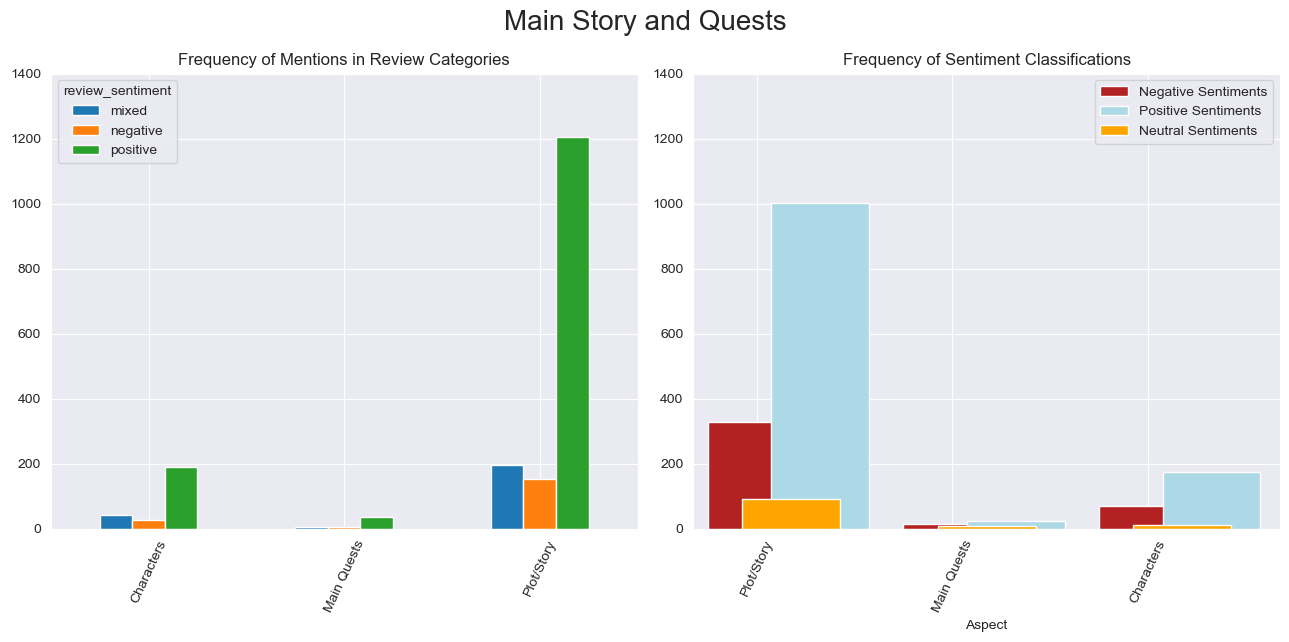

In [99]:
fig, ax = plt.subplots(1,2,figsize=(13,6.5))
fig.suptitle('Main Story and Quests', fontsize = 20)
elem, i, title = aggregated_aspects[4]
sentiment_proportions(aspect_sentiment_df,totk_reviews_wa,elem, i, title)

plt.tight_layout();

### Key Observations:
- Plot/Story: Almost 50 percent of our aspect containing reviews discuss this aspect. Extremely positive response. 

- Main Quests: Niche with a seemingly more mixed response. Once again we can see that the number of positive responses does not equate to the sum of mention in positive reviews.
- Characters: Overall Positive Response.

Note: "Main Quests" as an aspect is particular and distinct however it is possile user reviews would define them as being part of the Main Story experience and will discuss it under "Plot/Story". 


---------
## Abilities
  

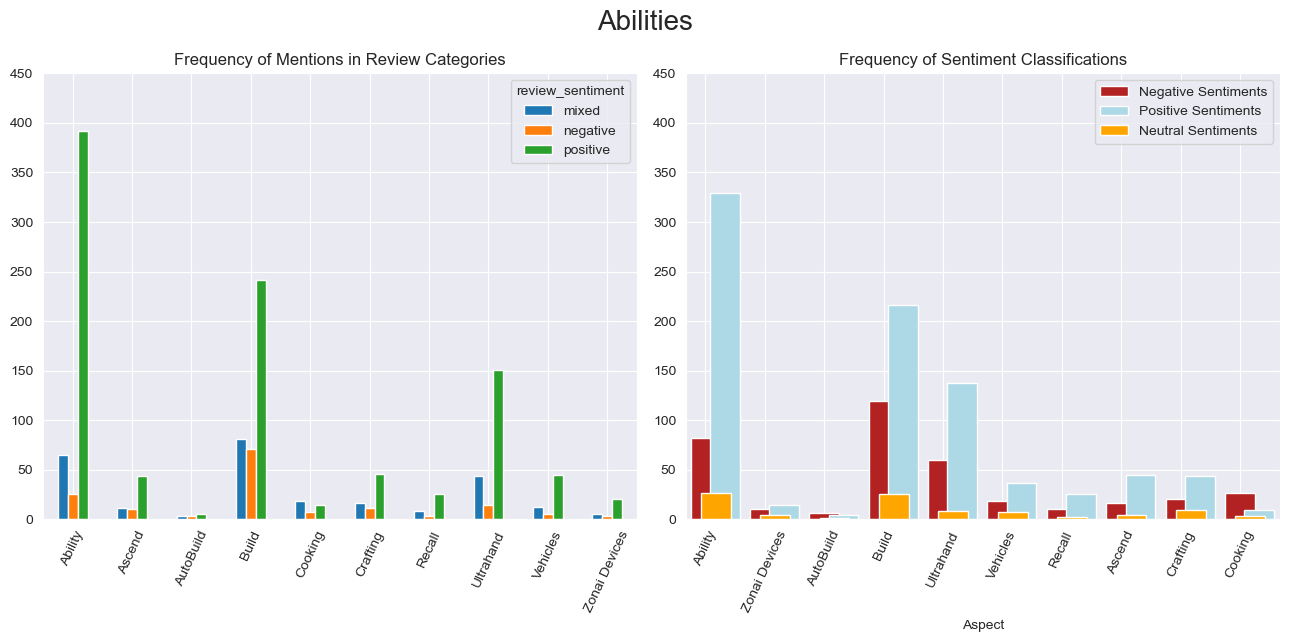

In [102]:
fig, ax = plt.subplots(1,2,figsize=(13,6.5))
fig.suptitle('Abilities', fontsize = 20)
elem, i, title = aggregated_aspects[5]
sentiment_proportions(aspect_sentiment_df,totk_reviews_wa,elem, i, title)

plt.tight_layout();

### Key Observations:
- Ability: An umbrella term for all abilities. A very positive response from the players.

#### Build, Ultrahand, Vehicles, Zonai Devices and Autobuild:
Ultrahand and Autobuild are abilties facilitating the construction of objects which can be used to solve puzzles or as vehicles. <br>
Zonai Devices are objects in game facilitating certain physics interactions. E.G. A. automatically spinning wheel, a steering mechanism, a fan etc and they can be used in the creation of objects and vehicles. <br>
"Build" is an umbrella term for constructing things in game. The nature of the abilities is such that players may not reference them directly rather discussing construction as a whole.
- Build: Predominant positive but there's about a 40:60 split between negative/neutral responses to positive responses. Indicating a welcome new mechanic that could benefit from further iteration.
- Autobuild: Very niche. Overall Negative response
- Zonai Devices: Positive
- Vehicles: Posiitive 

- Recall and Ascend: Positive 
- Crafting: Fuse, along with ultrahand and its related abilities are related to crafting and theres a positive response overall.
- Cooking: Sparsely mentionedand mostly in negative reviews, discussed mostly in a negative way. Future installments could optimise this feature or perhaps it requires a reinvention.
----------

## Side Quests and Side Adventures

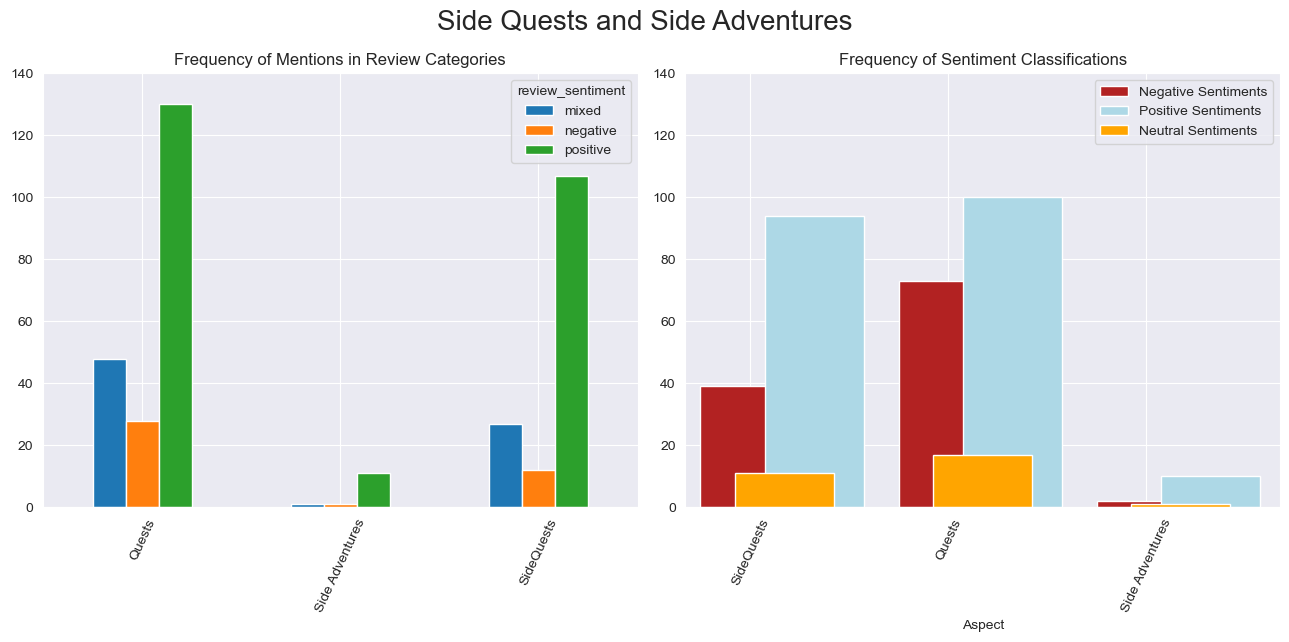

In [103]:
fig, ax = plt.subplots(1,2,figsize=(13,6.5))
fig.suptitle('Side Quests and Side Adventures', fontsize = 20)
elem, i, title = aggregated_aspects[6]
sentiment_proportions(aspect_sentiment_df,totk_reviews_wa,elem, i, title)

plt.tight_layout();

### Key Observations:
- Quests: Overall mixed response, noticeably fewer positive responses that mentions in positive reviews. Also a vague category as players may discuss to side quests, main quests, and side adventures as "quests". 
- Side Adventures: More in depth quests involving main characters and provide more meaningful in-game reward for players. While it's mentioned by few users (<20), there's a majority consesus among them that these type of quests are a good feature. Future installments could use side adventures as a template for future quest design.
- Side Quests: Positive response, though the margin isn't as strong as "Side Adventures". Once again it's possible for players to discuss "side adventures" as part of these responses.

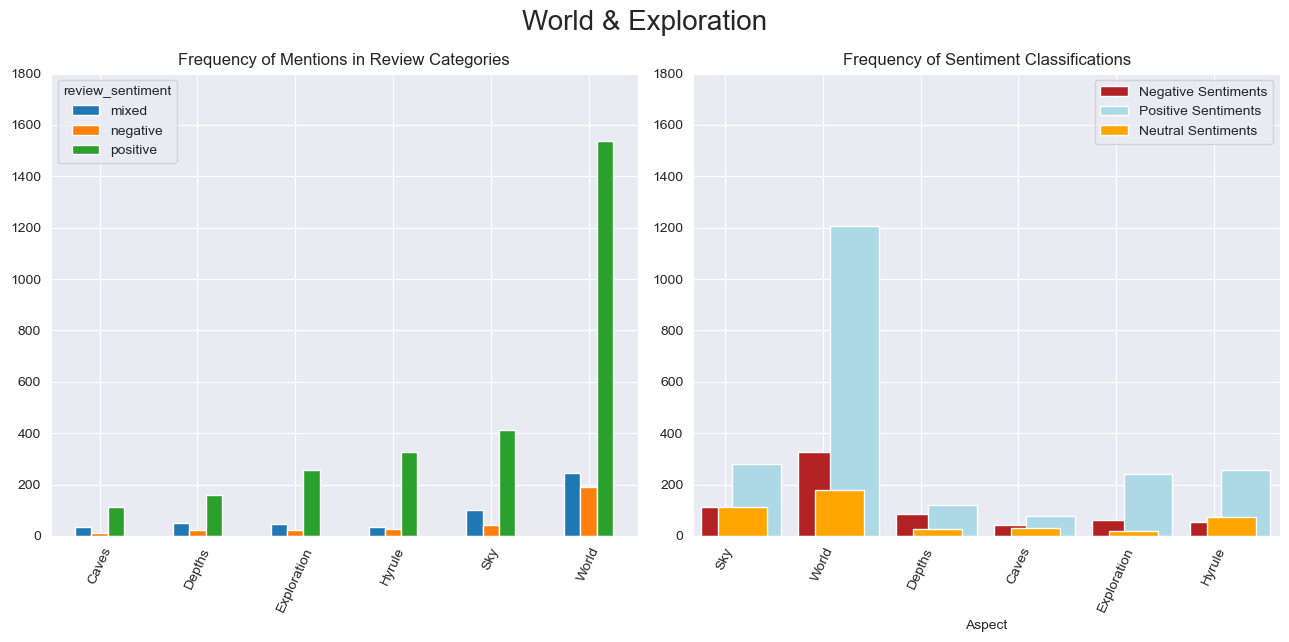

In [104]:
fig, ax = plt.subplots(1,2,figsize=(13,6.5))
fig.suptitle('World & Exploration', fontsize = 20)
elem, i, title = aggregated_aspects[7]
sentiment_proportions(aspect_sentiment_df,totk_reviews_wa,elem, i, title)

plt.tight_layout();

### Key Observations:
- Every aspect here is positively received.
- World: An aspect the encompasses all the others (except exploration) here and has an overwhelmingly positive response.
- Exploration: Positive response
- Sky: Notable for having a larger ratio of negative/netural responses to positive ones. While ther are ~300 positive responses theres still ~100 negative ones. I would say this has a mixed response. <br>
From the graphs is very clear that the games world and the parts that make it up are on the best creations of the developers. Or at least those who felt it worth mentioning.

-------

## Miscellaenous

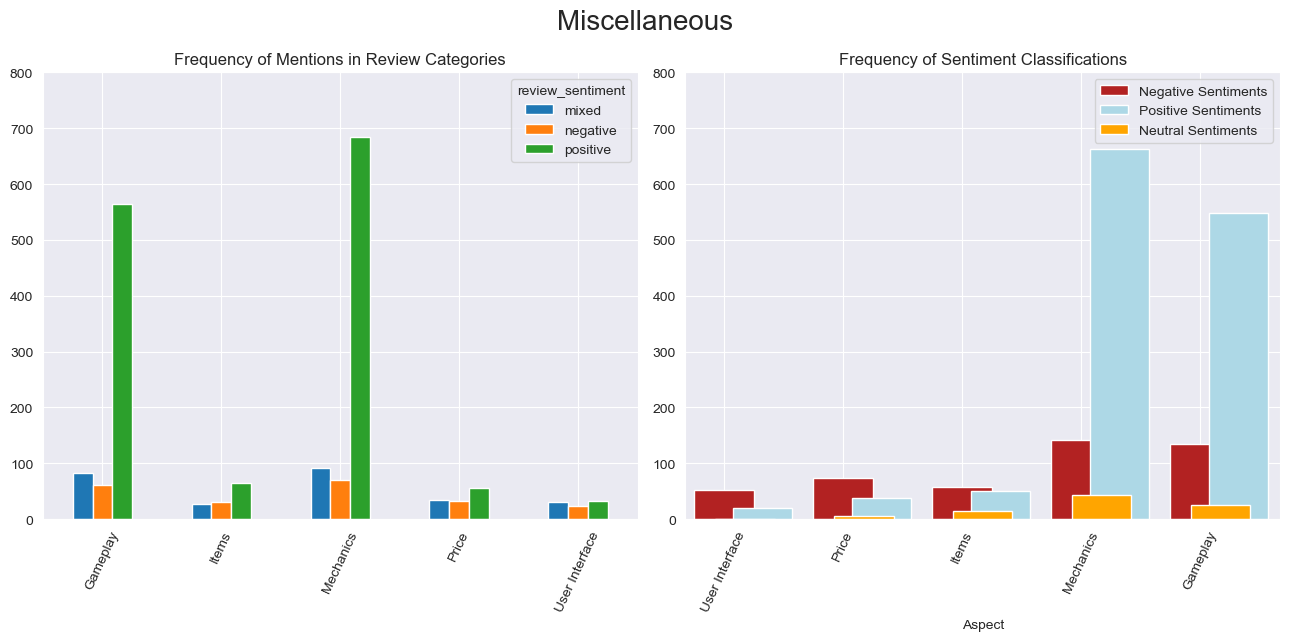

In [105]:
fig, ax = plt.subplots(1,2,figsize=(13,6.5))
fig.suptitle('Miscellaneous', fontsize = 20)
elem, i, title = aggregated_aspects[8]
sentiment_proportions(aspect_sentiment_df,totk_reviews_wa,elem, i, title)

plt.tight_layout();

### Key Observations:
- Gameplay: Practically encompasses every interactive element of a videogame and we can see it has an overwhelmingly positive response.
- Mechanics: Similar to gameplay it is a very vague term with an overwhelmingly positive response.

- Price: Niche with overall negative response (I doubt the found it too cheap).
- User Interface: Niche, with a significant margin of users having a negative opinion
- Items: A vague category as items could include weapons, crafting materials and cooking materials etc. It has a mixed response. 


## Most identifiable areas for Improvement:
- Framerate and technical performance: Likely a hardware issue but in future devs could consider balancing ambition with the practical capabilities of the hardware/platform.
- Weapon Durability: In future an alternative method could be devised to motivate players into constantly chaning and using a more diverse arsenal. The fuse mechanic, recieved positively seems to be a step in the right direction in this regard.
- Dungeons: While this aspect has mostly positive reception, the proportion of negative sentiments towards it warrants a more detailed inspection into the reasons why. Without improvement or iteration, dungeons of the same quality/style could be met with a more negative response in future entries.
- User Interface: Niche but when mentioned, a strong proportion of reviewers do not like UI.
- Price is a given. But in practical terms most games are expensive and unless there's a noticeable dip in sales. They will continue with a premium price point.
  


## Thoughts on User Reviews:


### How many aspects typically appear in reviews?
By inspecting the number of aspects that appear in reviews, we can get some insight as to how in depth user reviews can actually be. 
We would define a more 'in depth' review to discuss many aspects of a game in detail. 

-  Note: 65% of user reviews contained aspects (5170/3377) contained any aspects from the list above. This could be due to a limited set of pre-defined aspects.

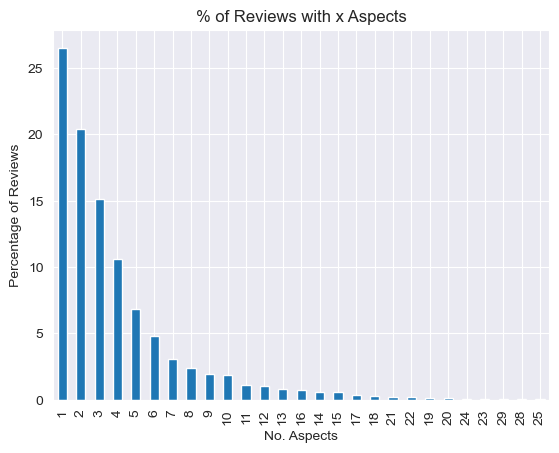

In [130]:

ax = (
    totk_reviews_wa#.query('review_sentiment == "mixed"')
                   .updated_aspects_within.apply(lambda x: len(x))
                   .value_counts()
                   .div(len(totk_reviews_wa))
                   .mul(100)
                   .plot.bar(title='% of Reviews with x Aspects')
);
ax.set_ylabel('Percentage of Reviews')
ax.set_xlabel('No. Aspects');

## Key Observations:
- Majority of reviews contain between 1 and 4 aspects.
- If most reviews only discuss this number of aspects, we can't rely on every user review to give granular feedback.
- These user reviews, in general do not go into the level of detail and so we should be aware of a "selection bias" that users have toward more obvious and indistinct aspects such as "graphics".


When we look at user reviews I don't think we can rely on "completeness" of feedback toward a videogame. Videogames are still ultimately emotional _immersive_ experiences and as such players can be distracted or may not be able to pinpoint their sources of frustration toward a game. As an example a game's UI can be inefficiently designed but if players do not "notice" it unless prompted they'll never indepently give feedback on it, or see how the games experience can be improved as a result of it changing.

--------
I'll leave the notebook with the most detailed of reviews: those with over 20 aspects.

In [161]:
revs_over19_aspects = (
    totk_reviews_wa.assign(num_aspects = lambda df_: df_.updated_aspects_within.
                                                        str.len())
                   .query('num_aspects > 19')
                   .review_text
                   .values
                   .tolist()
)
print('There are',len(revs_over19_aspects), 'reviews with over 19 aspects', '\n\n')
for rev in revs_over19_aspects:
    print(rev + '\n\n\n')


There are 26 reviews with over 19 aspects 


The most legendary series in video games makes history once again with a unique and practically perfect revolutionary colossal adventure that elevates the fun and freedom of the player to an unprecedented level. New in Tears of the Kingdom are the Zonai devices, which the player can use for combat, propulsion, exploration and **** runes from the previous game are replaced with five new powers: Ultrahand Fusion, Ascend, Back and the **** Ultrahand allows the player to pick up and move different objects and join different objects together. This can be used with the Zonai devices to create different vehicles or other constructs. Fusion allows Link to combine materials, equipment, or certain objects in the world into a shield or weapon to increase its attributes and **** for example fusing an explosive item with an arrow will cause the arrow to explode on impact. Autobuild instantly recreates a device created with Ultrahand at the cost of zonait